In [44]:
import pandas as pd
import numpy as np

from clustering_functions import *
from impute_transform import ImputeTransform
from fancyimpute import MatrixFactorization

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('ggplot')

# Unsupervised Learning in ADHD

## Introduction

[Subtyping ADHD Using Tempermant Dimensions](https://jamanetwork.com/journals/jamapsychiatry/fullarticle/1885709)

The above is a paper written by Dr. Karalunas et al., that utilized community detection analysis on the Temperment in Middle Childhood Questionnaire (TMCQ). They found 3 profiles of children, which they labeled as "mild", "surgent", and "irritable".

This made me curious to try different clustering algorithms on the TMCQ and Neuropsych data to see what phenotypes of temperment and neurocognitive ability seem to exist.

---

# TMCQ Cluster Analysis

## Prepare Data
Some notes on dataset preparation:
 - We are using the full dataset (n=901)
 - The data is imputed by Matrix Factorization based on the full dataset
 - The neuropsych dataset is scaled using sklearn's StandardScaler

In [7]:
%%capture
data = pd.read_csv('data/full_data.csv')
#small_data = data.sample(n=200)
TMCQ_all, TMCQ_adhd, TMCQ_control = prep_data(data, dataset='TMCQ')

In [5]:
print_ns(TMCQ_all, TMCQ_adhd, TMCQ_control)

Ns for each group
-----------------
All:      901
ADHD:     574
Control:  327


## Choose K for each group
With k-means cluster analysis, you must choose k yourself. Examining the within-cluster sum of scores and silhouette score by varying K is a good strategy for this.

The WCSS graph does not give us a great option for picking K based on the [elbow method](https://bl.ocks.org/rpgove/0060ff3b656618e9136b).

The silhouette graph is more useful - k=2 has the highest silhouette score, suggesting that's the best number of clusters to go with.

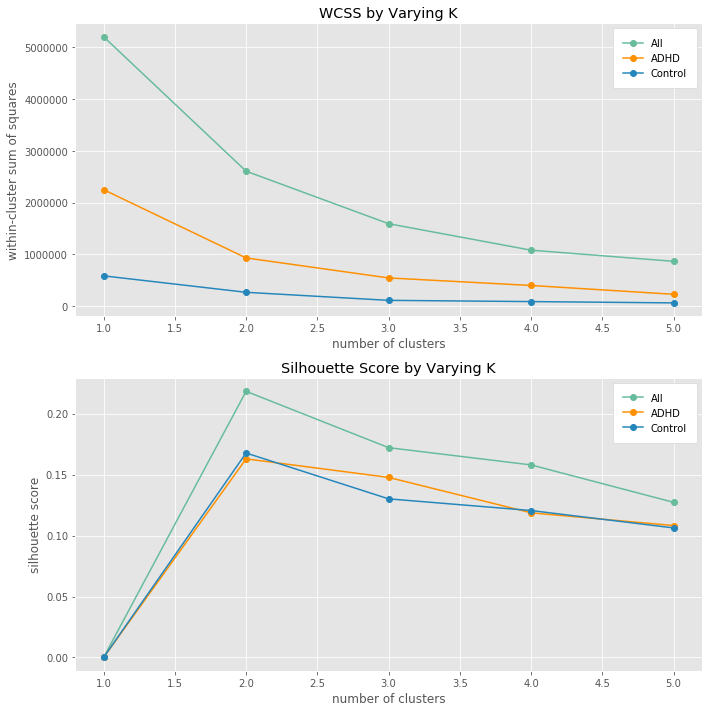

In [8]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
km = KMeans(n_jobs=-1)
wcss_and_silhouette(TMCQ_all, km, axs, 'All', '#67bc9c')
wcss_and_silhouette(TMCQ_adhd, km, axs, 'ADHD', '#ff9000')
wcss_and_silhouette(TMCQ_control, km, axs, 'Control', '#2586bc')
plt.tight_layout()

2 seems to be the best number of clusters for all groups.

## Group = All, K = 2

What kind of insights can we gain from the KMeans Cluster Analysis on the TMCQ dataset with all subjects?

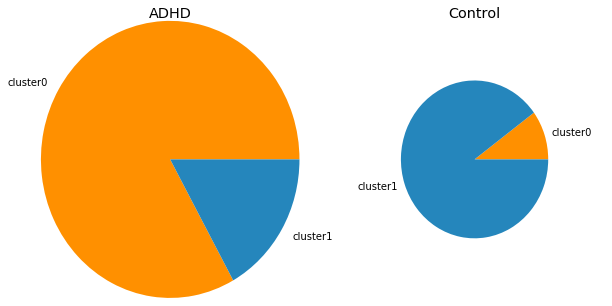

In [31]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
build_piechart(TMCQ_all, data, km, 'DX', axs)

Here we can see that Cluster 1 roughly corresponds to Control, and Cluster 0 roughly corresponds to ADHD.

Radius of the pie chart is: (N of the diagnosis group / total N) * 2

Below is proportions of clusters per DX group for DXSUB.

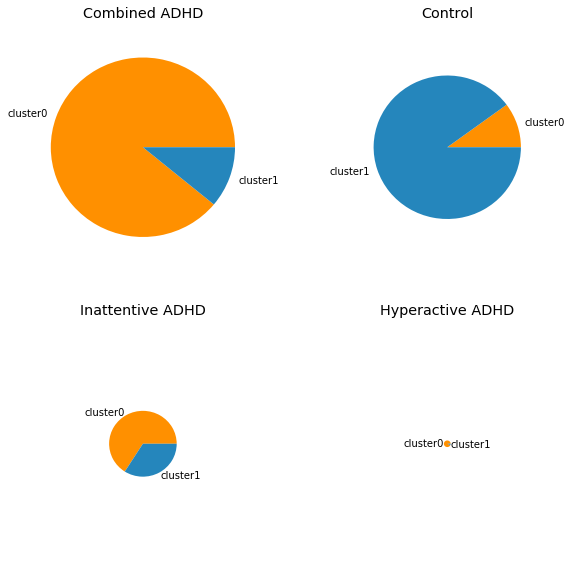

In [32]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
build_piechart(TMCQ_all, data, km, 'DXSUB', axs.flatten(),
               title_dict = {1.0: 'Control', 3.0:
                             'Inattentive ADHD', 4.0: 'Hyperactive ADHD', 5.0: 'Combined ADHD'})

This is a little less informative (particularly for Inattentive and Hyperactive ADHD because of their low Ns). However we see the same pattern of Cluster 0 corresponding to ADHD subtypes.

## Group = ADHD, Control, K = 2

We will now examine the TMCQ scores. We split the TMCQ dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean TMCQ scores in each cluster between the groups.

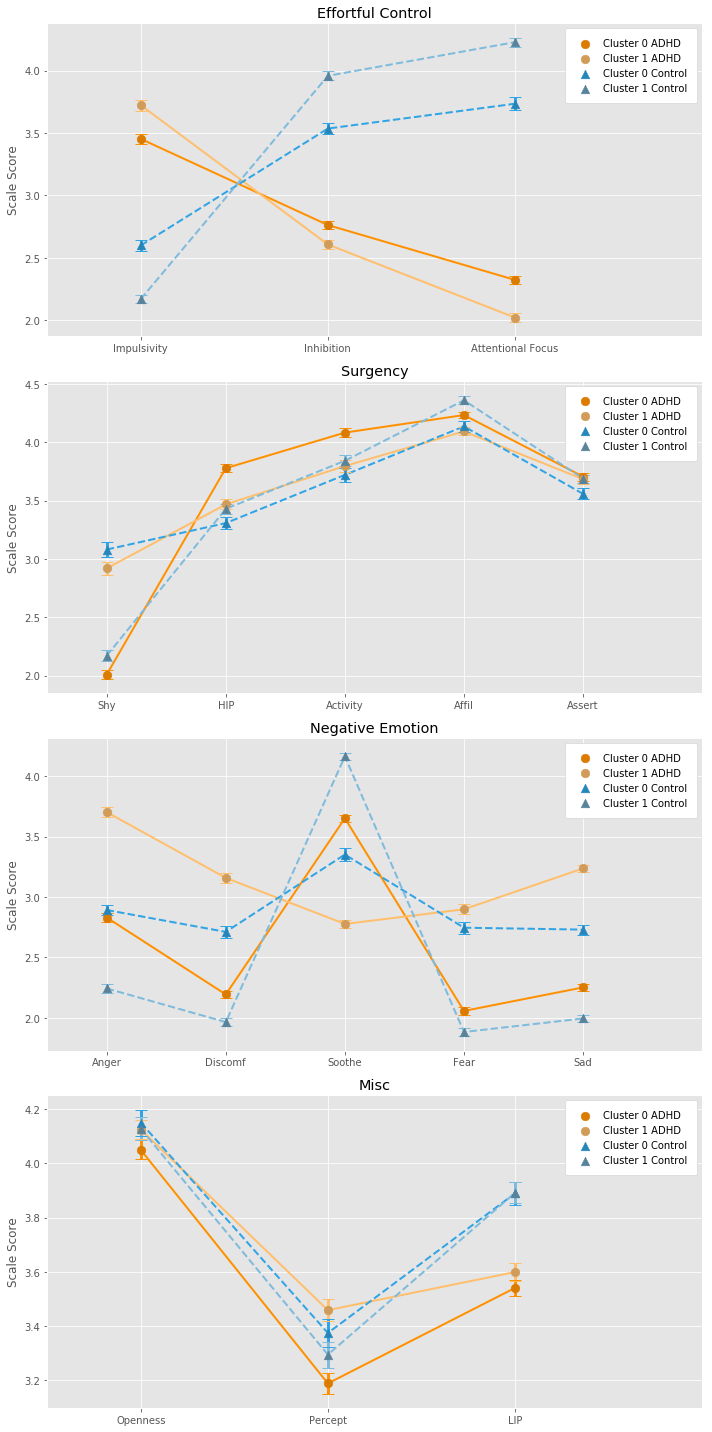

In [13]:
fig, axs = plt.subplots(4,1,figsize=(10,20))

km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
run_ADHD_Control_k2(TMCQ_adhd, TMCQ_control, km, axs, dataset='TMCQ')

plt.tight_layout()

Some observations:
 - ADHD clusters have worse effortful control
 - There seems to be an ADHD cluster with high negative emotion (corresponding to the idea of an 'irritable' subtype')

---

# Neuropsych Cluster Analysis

Now we will examine the neuropsych-only dataset.

## Prepare Data

In [14]:
%%capture
data = pd.read_csv('data/full_data.csv')
#small_data = data.sample(n=200)
neuro_all, neuro_adhd, neuro_control = prep_data(data, dataset='neuro')

In [38]:
print_ns(neuro_all, neuro_adhd, neuro_control)

Ns for each group
-----------------
All:      901
ADHD:     574
Control:  327


## Choose K for each group

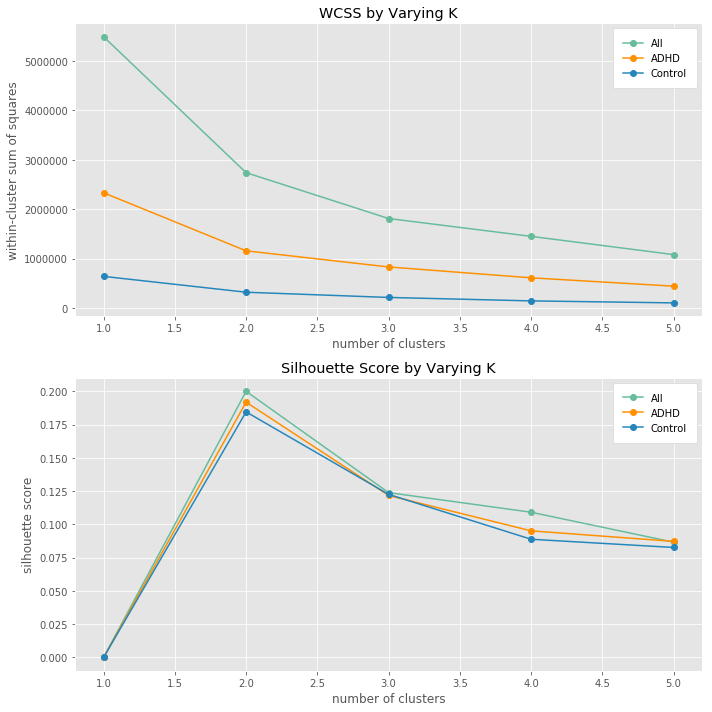

In [40]:
fig, axs = plt.subplots(2,1,figsize=(10,10))

scaler = StandardScaler()
kmeans = KMeans(n_jobs=-1, random_state=56)
steps = [('standard_scaler', scaler),
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

wcss_and_silhouette(neuro_all, pipeline, axs, 'All', '#67bc9c', standard_scale=True)
wcss_and_silhouette(neuro_adhd, pipeline, axs, 'ADHD', '#ff9000', standard_scale=True)
wcss_and_silhouette(neuro_control, pipeline, axs, 'Control', '#2586bc', standard_scale=True)

plt.tight_layout()

Again, 2 seems to be the best number of clusters for all groups.

## Group = All, K = 2

What kind of insights can we gain from the KMeans Cluster Analysis on the neuro dataset with all subjects?

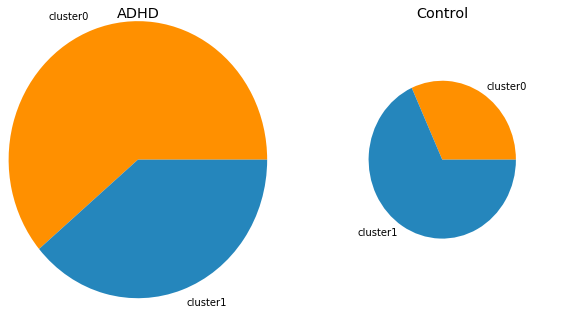

In [41]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

scaler = StandardScaler()
kmeans = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
steps = [('standard_scaler', scaler),
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

build_piechart(neuro_all, data, pipeline, 'DX', axs)

Here we can see that Cluster 0 roughly corresponds to Control, and Cluster 1 roughly corresponds to ADHD. The deliniation is not as good as in the TMCQ dataset.

Radius of the pie chart is: (N of the diagnosis group / total N) * 2

Below is proportions of clusters per DX group for DXSUB.

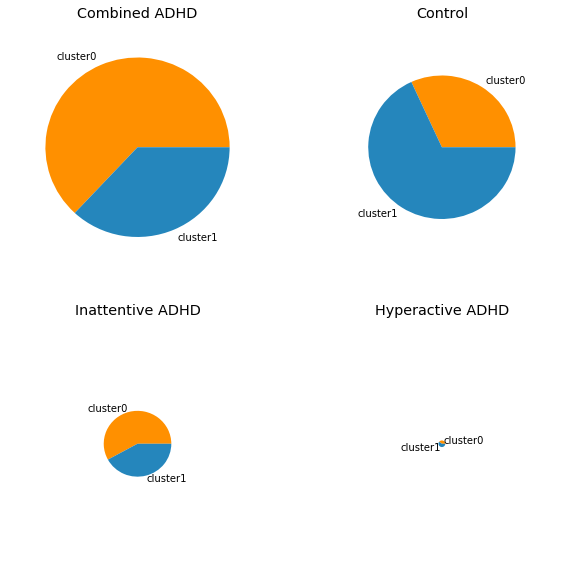

In [42]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
build_piechart(neuro_all, data, pipeline, 'DXSUB', axs.flatten(),
               title_dict = {1.0: 'Control', 3.0: 'Inattentive ADHD', 4.0: 'Hyperactive ADHD', 5.0: 'Combined ADHD'})

This is a little less informative (particularly for Inattentive and Hyperactive ADHD because of their low Ns). However we see the same pattern of Cluster 1 corresponding to ADHD subtypes.

## Group = ADHD, Control, K = 2

We will now examine the neuro scores. We normalize the whole dataset, and then split the neuro dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean neuro scores in each cluster between the groups.

In [9]:
%%capture
data = pd.read_csv('data/full_data.csv')
neuro_all, neuro_adhd, neuro_control = prep_data(data, dataset='neuro', scale='before')

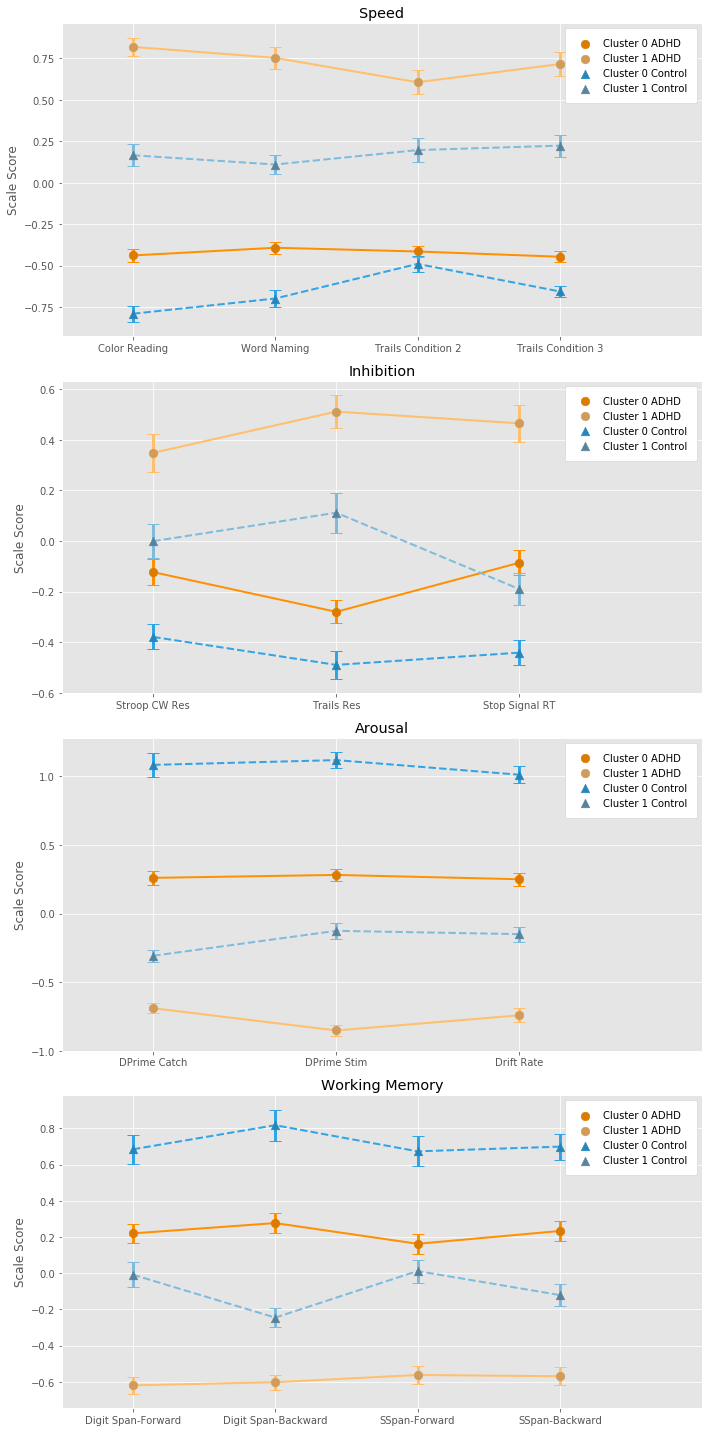

In [11]:
fig, axs = plt.subplots(4,1,figsize=(10,20))

km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
run_ADHD_Control_k2(neuro_adhd, neuro_control, km, axs.flatten(), dataset='neuro')

plt.tight_layout()

Some observations:
 - Seems to be a high/low group within each domain
 - ADHD always performs worse within these groups

---

# Statistical Tests

I used Benjamini-Hochberg FDR Control to correct for multiple testing. The FDR is set at 0.05. I am comparing the means of each combination of clusters within a scale.

In [12]:
import scipy.stats as scs
from itertools import combinations

In [13]:
%%capture
data = pd.read_csv('data/full_data.csv')
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
cluster_data = combine_datasets(data, km)

In [14]:
p_val_df = run_mannwhitneyu_all(cluster_data)

In [15]:
p_val_df.head()

,p-val,rank,(i/m)Q,sig?
a_c0_c_c0_AttFocus,8.465164e-76,1,0.000269,True
a_c1_c_c0_AttFocus,7.731925e-70,2,0.000538,True
a_c0_a_c1_Sad,8.010410e-70,3,0.000806,True
a_c1_c_c0_Sad,4.201593e-65,4,0.001075,True
a_c1_c_c0_Soothe,7.448167e-64,5,0.001344,True


Out of 186 Mann-Whitney U tests on the TMCQ/neuro cluster analysis, 160 were statistically significant. This suggests that the cluster analysis was able to identify the distinct temperment and neurocognitive characteristics in children with and without ADHD.

---

# Bringing It Back Together

Is there any connection between the clusters seen in TMCQ scores, and clusters seen in neuropsych data?

To examine this, we look at confusion matrices for ADHD and control. The numbers returned are percentages.

In [24]:
%%capture
data = pd.read_csv('data/full_data.csv')
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
cluster_data = combine_datasets(data, km)

In [16]:
cluster_data.head()

,Unnamed: 0,STOP_SSRTAVE_Y1,DPRIME1_Y1,DPRIME2_Y1,SSBK_NUMCOMPLETE_Y1,SSFD_NUMCOMPLETE_Y1,V_Y1,Y1_CLWRD_COND1,Y1_CLWRD_COND2,Y1_DIGITS_BKWD_RS,...,Y1_P_TMCQ_PERCEPT,Y1_P_TMCQ_DISCOMF,Y1_P_TMCQ_OPENNESS,Y1_P_TMCQ_SURGENCY,Y1_P_TMCQ_EFFCONT,Y1_P_TMCQ_NEGAFFECT,DX,DXSUB,neuro_cluster,TMCQ_cluster
0,0.0,285.835000,0.237440,-0.125579,9.0,9.0,2.691400,36.0,28.0,7.0,...,2.777778,2.555556,4.222222,3.962290,4.062460,1.934841,1.0,1.0,0.0,0.0
1,1.0,330.953135,0.231609,0.946903,5.0,7.0,2.110019,67.0,49.0,7.0,...,4.800000,3.571429,4.600000,3.916667,3.253333,3.486667,3.0,3.0,0.0,1.0
2,2.0,292.937949,1.287838,2.603895,11.0,7.0,2.709627,45.0,26.0,7.0,...,3.800000,2.800000,4.777778,3.022222,3.950000,2.500397,1.0,1.0,1.0,1.0
3,3.0,295.493541,0.186778,1.313471,3.0,7.0,2.538208,53.0,49.0,6.0,...,2.968927,2.159874,3.748012,3.841795,2.669170,2.505711,3.0,5.0,0.0,0.0
4,4.0,326.161525,0.634811,1.626384,11.0,7.0,2.271908,54.0,36.0,6.0,...,4.000000,4.000000,4.857143,3.903704,3.473333,4.265952,3.0,5.0,0.0,1.0


In [102]:
adhd_cluster, control_cluster = cluster_matrix(cluster_data)

In [103]:
adhd_cluster

,TMCQ Cluster 0,TMCQ Cluster 1
Neuro Cluster 0,0.297909,0.212544
Neuro Cluster 1,0.278746,0.210801


In [104]:
control_cluster

,TMCQ Cluster 0,TMCQ Cluster 1
Neuro Cluster 0,0.272171,0.146789
Neuro Cluster 1,0.296636,0.284404


It's hard to tell if there's any pattern between which cluster a child belongs to in the TMCQ dataset, and the neuropsych dataset. Let's run some statistical tests to determine as such.

I ran Mann-Whitney U tests on each cluster combo type within the ADHD and Control datasets. 

I used the Benjamini Hochberg Control, FDR = 0.05

How to read the cluster_combo_df:
 - Row name is DX\_[ClusterComboA]\_[ClusterComboB]
 - Cluster combo IDs have the cluster number from Neuro (0N) and cluster number from TMCQ (1T), to equal 0N_1T (for example)

In [49]:
adhd_dummies, control_dummies = make_dummy_matrix(cluster_data)

In [36]:
control_dummies.head()

,0N_0T,0N_1T,1N_0T,1N_1T
0,1,0,0,0
2,0,0,0,1
6,0,1,0,0
8,0,1,0,0
9,0,1,0,0


In [51]:
cluster_combo_df = run_mannwhitney_clusters(adhd_dummies, control_dummies)

In [52]:
cluster_combo_df

,p-val,rank,(i/m)Q,sig?
ADHD_0N_1T_1N_0T,0.000353,1,0.004167,True
Control_0N_1T_1N_0T,0.000353,2,0.008333,True
ADHD_1N_0T_1N_1T,0.001217,3,0.012500,True
Control_1N_0T_1N_1T,0.001217,4,0.016667,True
ADHD_0N_0T_0N_1T,0.007908,5,0.020833,True
Control_0N_0T_0N_1T,0.007908,6,0.025000,True
ADHD_0N_0T_1N_1T,0.019898,7,0.029167,True
Control_0N_0T_1N_1T,0.019898,8,0.033333,True
ADHD_0N_0T_1N_0T,0.163459,9,0.037500,False
Control_0N_0T_1N_0T,0.163459,10,0.041667,False


Several cluster combos proportions are significantly different when compared to each other.

Next steps may involve further identifying these cluster combinations and naming them.